In [1]:
import pandas as pd
from news_paper_dao import NewsPaperDao
from IPython.core.display import HTML
from os import getcwd
from news_paper_nlp_pre_processing import *
from nltk.corpus import stopwords, wordnet
import nltk

In [2]:
# Récupère le répertoire du programme
curent_path = getcwd()+ "\\"
if "ema_lannuontimes" not in curent_path:
    curent_path += "PROJETS\\ema_lannuontimes\\"
print(curent_path)

c:\Users\User\WORK\workspace-ia\PROJETS\ema_lannuontimes\


<div style="display: flex; background-color: Blue; padding: 15px;" >

## 1.Exploration des données: 
</div>

In [3]:
verbose = 1

dao = NewsPaperDao(nom_bdd=curent_path+"em_bdd.db")
assert dao.test_connexion()

df_articles = dao.get_articles(verbose=0)
print(df_articles.shape)

La version de SQLite est:  [('3.35.5',)]
(1185, 7)


In [4]:
color_by_journal = {"Le Trégor":"green","ActuGaming":"orange", "Elle":"pink", "30 M. d\\'amis":"blue"}
journaux = df_articles["journal"].unique()

In [5]:
print(df_articles.shape)
print(df_articles.columns)
display(HTML(df_articles.head().to_html()))

(1185, 7)
Index(['titre', 'date_parution', 'journal', 'auteur', 'tags', 'texte', 'url'], dtype='object')


,titre,date_parution,journal,auteur,tags,texte,url
0,Lannion. Un cycliste renversé par une voiture en centre-ville,10 Mar 22 à 17:05,Le Trégor,Christophe Ganne,faits-divers,"Jeudi 10 mars à 16 h 30, au rond point de la Poste à Lannion, en plein centre-ville, sur les quais, un cycliste a été renversé par une voiture. Légèrement blessé Le jeune cycliste, âgé de seize ans, a été légèrement blessé. Pompiers et policiers se sont rapidement rendus sur place. Le jeune homme a été pris en charge par les pompiers et transporté au centre hospitalier de Lannion.",https://actu.fr/bretagne/lannion_22113/lannion-un-cycliste-renverse-par-une-voiture-en-centre-ville_49325798.html
1,Perros-Guirec. Panne électrique : la mairie invite les citoyens à économiser l\'énergie,8 Mar 22 à 10:33,Le Trégor,Christophe Ganne,societe,"Suite à la panne d’électricité géante sur la côte de Granit rose, ce week-end, de nombreuses coupures sont encore attendues jour et nuit. Les difficultés de réparation du poste de Saint-Quay-Perros vont encore durer un moment. Pas d’éclairage public Pour faire face, la mairie de Perros-Guirec va dès ce mardi soir 8 mars couper l’éclairage public. Nous avons 80 postes de répartition de l’éclairage public que nous allons couper, peut-être pas tout ce soir, mais dans les jours suivants. C’est une mesure d’économie pour ne pas trop tirer sur les installations précaires mises en place en attendant la réparation définitive. Economiser l’électricité Cette mesure publique s’accompagne aussi d’encouragements envers la population. Nous allons demander aux Perrosiens d’être vigilants sur leur consommation électrique le temps des réparations. Les élus confirment aussi les difficultés d’approvisionnement en gasoil des 124 groupes électrogènes installés dans les différentes communes de la côte de Granit rose. Les activités nautiques interdites Autre conséquence, les difficultés de fonctionnement des stations d’épuration. Les postes de relevage et de traitement ne fonctionnent pas normalement. La ville craint des débordements qui pourraient atteindre les plages. « Ce n’est pas encore le cas mais il y a des risques », explique Erven Léon. C’est pourquoi la mairie de Perros-Guirec a pris un arrêté interdisant les baignades et les activités nautiques sur les plages de Trestraou, Trestrignel et Saint-Guirec le temps d’un retour à la normale.",https://actu.fr/bretagne/perros-guirec_22168/perros-guirec-panne-electrique-la-mairie-invite-les-citoyens-a-economiser-lenergie_49242304.html
2,Louannec. Un gang de l\'Est avait pillé le distributeur de billets : 5 interpellations,11 Mar 22 à 20:08,Le Trégor,Christophe Ganne,faits-divers,"Les gendarmes de Perros-Guirec, Lannion, Rennes, Toulouse et le groupe de cybercriminalité de la gendarmerie ont pu interpeller les membres d’un groupe qui piratait les distributeurs il y a quelques jours. Liés à la criminalité Les membres de ce groupe sont liés à la criminalité organisée des pays de l’Est. Ils avaient dérobé 50 000 euros à Louannec. 50 000 euros à Louannec Les faits remontent à la nuit du 9 au 10 novembre 2021. A l’agence postale de Louannec, les individus percent le distributeur automatique afin de le pirater en se connectant dessus à l’aide d’un ordinateur. Une pratique connue appelée Jackpotting Le groupe repart avec 50 000 euros. Les gendarmes de Perros-Guirec et Lannion, appuyés par ceux de Rennes, mènent l’enquête. Des points communs Parallèlement, à Auch et Toulouse, des faits similaires sont relevés. Les enquêteurs mettent en commun leurs recherches et y trouvent des points communs. Le 3 février dernier, dans le sud ouest, les gendarmes de Toulouse ont interpellé 5 individus. 22 piratages pour 300 000 euros Ils ont reconnu avoir piraté 22 distributeurs de billets dans toute la France pour un montant total de 300 000 euros dont 50 000 euros à Louannec. C’est une opération énorme qui a été montée et une organisation qui a été démantelée. L’enquête se poursuit toutefois pour d’autres faits. Certains 

In [6]:
import matplotlib.pyplot as plt

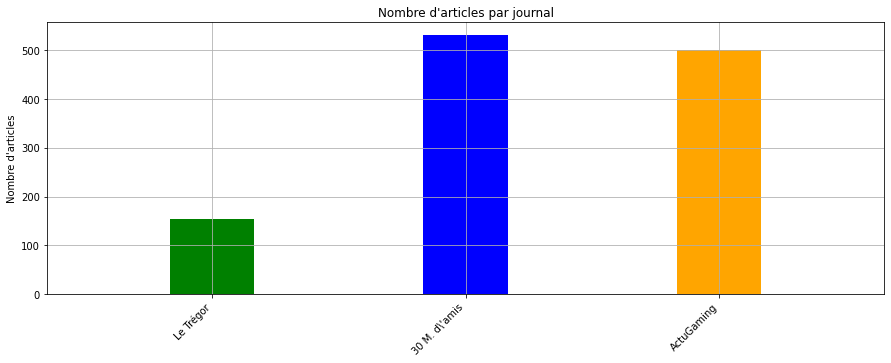

In [7]:
figure, axe = color_graph_background(1, 1)

bins = len(journaux)
for journal in journaux:
    df_articles[df_articles["journal"]==journal].journal.hist(ax=axe, color=color_by_journal.get(journal, "gray"), bins=bins)

figure.set_size_inches(15, 5, forward=True)
axe.set_ylabel("Nombre d'articles")
plt.title("Nombre d'articles par journal")
plt.xticks(rotation=45, ha="right")
plt.show()

In [8]:
df_articles = df_word_tokenize(df_articles, text_col_name='texte', token_col_name="mots_origine", verbose=verbose)

In [9]:
df_articles["nb_mots_origine"] = df_articles['texte'].apply(lambda x: word_count_func(x))

In [10]:
group = df_articles.groupby(["journal"], as_index=True).agg({'nb_mots_origine':['mean']})
group = group.reset_index()
group


,journal,nb_mots_origine
,,mean
0,30 M. d\'amis,1315.494340
1,ActuGaming,321.342000
2,Le Trégor,296.096774


In [11]:
df_articles.columns

Index(['titre', 'date_parution', 'journal', 'auteur', 'tags', 'texte', 'url',
       'mots_origine', 'nb_mots_origine'],
      dtype='object')

In [12]:
list_tuple = [(i, i+299) for i in range (600, 3300, 300)]
list_tuple.insert(0, (200, 299))
list_tuple.insert(0, (100, 199))
list_tuple.insert(0, (0, 99))
list_tuple.append((3300, 100000))
bins = pd.IntervalIndex.from_tuples(list_tuple)
df_articles["tranche_nb_origin"] = pd.cut(df_articles['nb_mots_origine'], bins)
df_articles.head()

,titre,date_parution,journal,auteur,tags,texte,url,mots_origine,nb_mots_origine,tranche_nb_origin
0,Lannion. Un cycliste renversé par une voiture ...,10 Mar 22 à 17:05,Le Trégor,Christophe Ganne,faits-divers,"Jeudi 10 mars à 16 h 30, au rond point de la P...",https://actu.fr/bretagne/lannion_22113/lannion...,"[jeudi, 10, mars, à, 16, h, 30, au, rond, poin...",69,"(0.0, 99.0]"
1,Perros-Guirec. Panne électrique : la mairie in...,8 Mar 22 à 10:33,Le Trégor,Christophe Ganne,societe,Suite à la panne d’électricité géante sur la c...,https://actu.fr/bretagne/perros-guirec_22168/p...,"[suite, à, la, panne, d, électricité, géante, ...",233,"(200.0, 299.0]"
2,Louannec. Un gang de l\'Est avait pillé le dis...,11 Mar 22 à 20:08,Le Trégor,Christophe Ganne,faits-divers,"Les gendarmes de Perros-Guirec, Lannion, Renne...",https://actu.fr/bretagne/louannec_22134/louann...,"[les, gendarmes, de, perros, guirec, lannion, ...",228,"(200.0, 299.0]"
3,Lannion. Une conférence et une expo sur l’hydr...,9 Mar 22 à 12:25,Le Trégor,Rédaction Lannion,Actualité,L’association ArmorScience propose à l’IUT de ...,https://actu.fr/bretagne/lannion_22113/lannion...,"[l, association, armorscience, propose, à, l, ...",236,"(200.0, 299.0]"
4,Autour de Perros. Panne : des groupes électrog...,11 Mar 22 à 12:21,Le Trégor,Rédaction Lannion,societe,"Le village vacances de la CCAS, à Trébeurden, ...",https://actu.fr/bretagne/trebeurden_22343/auto...,"[le, village, vacances, de, la, ccas, à, trébe...",422,NaN


In [13]:
group_nb_mots_art = df_articles.groupby(["journal", "tranche_nb_origin" ])["titre"].count().unstack("journal").fillna(0)
group_nb_mots_art.head()

journal,30 M. d\'amis,ActuGaming,Le Trégor
tranche_nb_origin,,,
"(0, 99]",0,14,7
"(100, 199]",0,96,46
"(200, 299]",5,231,50
"(600, 899]",83,11,12
"(900, 1199]",97,11,0


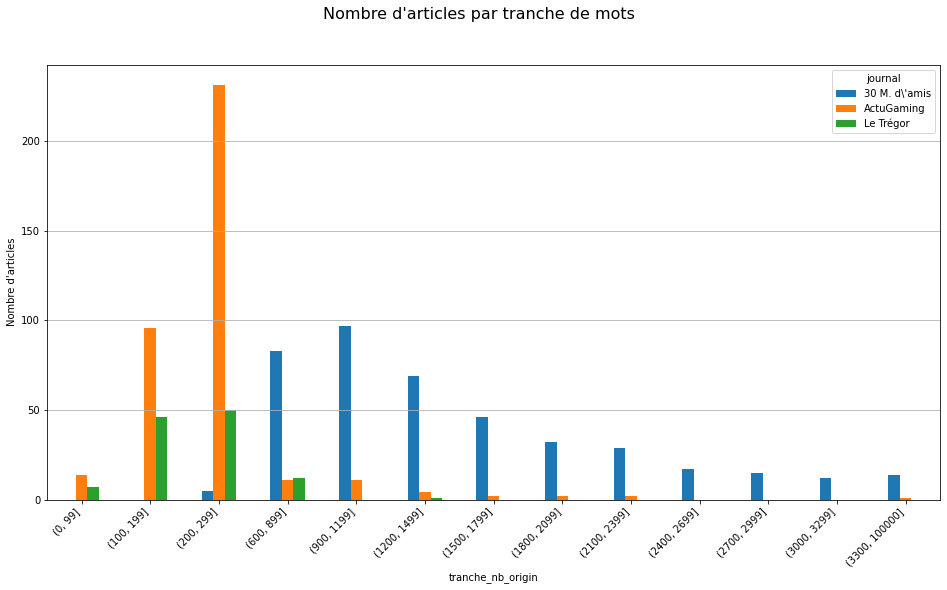

In [14]:
figure, axe = color_graph_background(1,1)

# Affichage d'articles par journal
group_nb_mots_art.plot(kind='bar', ax=axe)
axe.set_ylabel("Nombre d'articles")
axe.grid(axis='y')

figure.set_size_inches(16, 8, forward=True)
figure.suptitle("Nombre d'articles par tranche de mots", fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.show()

In [15]:
df_articles.describe()

,nb_mots_origine
count,1185.000000
mean,762.681857
std,797.149464
min,60.000000
25%,239.000000
50%,413.000000
75%,1041.000000
max,6930.000000


In [16]:
df_articles.head()

,titre,date_parution,journal,auteur,tags,texte,url,mots_origine,nb_mots_origine,tranche_nb_origin
0,Lannion. Un cycliste renversé par une voiture ...,10 Mar 22 à 17:05,Le Trégor,Christophe Ganne,faits-divers,"Jeudi 10 mars à 16 h 30, au rond point de la P...",https://actu.fr/bretagne/lannion_22113/lannion...,"[jeudi, 10, mars, à, 16, h, 30, au, rond, poin...",69,"(0.0, 99.0]"
1,Perros-Guirec. Panne électrique : la mairie in...,8 Mar 22 à 10:33,Le Trégor,Christophe Ganne,societe,Suite à la panne d’électricité géante sur la c...,https://actu.fr/bretagne/perros-guirec_22168/p...,"[suite, à, la, panne, d, électricité, géante, ...",233,"(200.0, 299.0]"
2,Louannec. Un gang de l\'Est avait pillé le dis...,11 Mar 22 à 20:08,Le Trégor,Christophe Ganne,faits-divers,"Les gendarmes de Perros-Guirec, Lannion, Renne...",https://actu.fr/bretagne/louannec_22134/louann...,"[les, gendarmes, de, perros, guirec, lannion, ...",228,"(200.0, 299.0]"
3,Lannion. Une conférence et une expo sur l’hydr...,9 Mar 22 à 12:25,Le Trégor,Rédaction Lannion,Actualité,L’association ArmorScience propose à l’IUT de ...,https://actu.fr/bretagne/lannion_22113/lannion...,"[l, association, armorscience, propose, à, l, ...",236,"(200.0, 299.0]"
4,Autour de Perros. Panne : des groupes électrog...,11 Mar 22 à 12:21,Le Trégor,Rédaction Lannion,societe,"Le village vacances de la CCAS, à Trébeurden, ...",https://actu.fr/bretagne/trebeurden_22343/auto...,"[le, village, vacances, de, la, ccas, à, trébe...",422,NaN


In [17]:
df_articles.columns

Index(['titre', 'date_parution', 'journal', 'auteur', 'tags', 'texte', 'url',
       'mots_origine', 'nb_mots_origine', 'tranche_nb_origin'],
      dtype='object')

<div style="display: flex; background-color: Blue; padding: 15px;" >

## 3.NLP Preprocessing
</div>

In [18]:
personnal_stop_word = ["tout", "tous", "cette", "bien", "comme", "encore", "autre", "bien", "tres", "alors", "plus", "aussi", "si", "donc", "p", "h", "etre"]
if personnal_stop_word is None:
    personnal_stop_word = stopwords.words("french")
else :
    personnal_stop_word.extend(stopwords.words("french"))
len(personnal_stop_word)

174

In [19]:
def nlp_pre_process(input, sw=None, verbose=0):
    res = []
    res = tokenize(input)
    res = remove_stopwords_func(res, sw=sw)
    res = normalize_accented_chars(res)
    res = remove_irr_char_func(res)        
    res = remove_stopwords_func(res, sw=sw)
        
    res = list(filter(None, res))
    return res

In [20]:
df_articles["clean_words"] = df_articles['texte'].apply(lambda x: nlp_pre_process(x, sw=personnal_stop_word))
print(df_articles.columns)
display(HTML(df_articles.head().to_html()))

Index(['titre', 'date_parution', 'journal', 'auteur', 'tags', 'texte', 'url',
       'mots_origine', 'nb_mots_origine', 'tranche_nb_origin', 'clean_words'],
      dtype='object')


,titre,date_parution,journal,auteur,tags,texte,url,mots_origine,nb_mots_origine,tranche_nb_origin,clean_words
0,Lannion. Un cycliste renversé par une voiture en centre-ville,10 Mar 22 à 17:05,Le Trégor,Christophe Ganne,faits-divers,"Jeudi 10 mars à 16 h 30, au rond point de la Poste à Lannion, en plein centre-ville, sur les quais, un cycliste a été renversé par une voiture. Légèrement blessé Le jeune cycliste, âgé de seize ans, a été légèrement blessé. Pompiers et policiers se sont rapidement rendus sur place. Le jeune homme a été pris en charge par les pompiers et transporté au centre hospitalier de Lannion.",https://actu.fr/bretagne/lannion_22113/lannion-un-cycliste-renverse-par-une-voiture-en-centre-ville_49325798.html,"[jeudi, 10, mars, à, 16, h, 30, au, rond, point, de, la, poste, à, lannion, en, plein, centre, ville, sur, les, quais, un, cycliste, a, été, renversé, par, une, voiture, légèrement, blessé, le, jeune, cycliste, âgé, de, seize, ans, a, été, légèrement, blessé, pompiers, et, policiers, se, sont, rapidement, rendus, sur, place, le, jeune, homme, a, été, pris, en, charge, par, les, pompiers, et, transporté, au, centre, hospitalier, de, lannion]",69,"(0.0, 99.0]","[jeudi, mars, rond, point, poste, lannion, plein, centre, ville, quais, cycliste, a, renverse, voiture, legerement, blesse, jeune, cycliste, age, seize, ans, a, legerement, blesse, pompiers, policiers, rapidement, rendus, place, jeune, homme, a, pris, charge, pompiers, transporte, centre, hospitalier, lannion]"
1,Perros-Guirec. Panne électrique : la mairie invite les citoyens à économiser l\'énergie,8 Mar 22 à 10:33,Le Trégor,Christophe Ganne,societe,"Suite à la panne d’électricité géante sur la côte de Granit rose, ce week-end, de nombreuses coupures sont encore attendues jour et nuit. Les difficultés de réparation du poste de Saint-Quay-Perros vont encore durer un moment. Pas d’éclairage public Pour faire face, la mairie de Perros-Guirec va dès ce mardi soir 8 mars couper l’éclairage public. Nous avons 80 postes de répartition de l’éclairage public que nous allons couper, peut-être pas tout ce soir, mais dans les jours suivants. C’est une mesure d’économie pour ne pas trop tirer sur les installations précaires mises en place en attendant la réparation définitive. Economiser l’électricité Cette mesure publique s’accompagne aussi d’encouragements envers la population. Nous allons demander aux Perrosiens d’être vigilants sur leur consommation électrique le temps des réparations. Les élus confirment aussi les difficultés d’approvisionnement en gasoil des 124 groupes électrogènes installés dans les différentes communes de la côte de Granit rose. Les activités nautiques interdites Autre conséquence, les difficultés de fonctionnement des stations d’épuration. Les postes de relevage et de traitement ne fonctionnent pas normalement. La ville craint des débordements qui pourraient atteindre les plages. « Ce n’est pas encore le cas mais il y a des risques », explique Erven Léon. C’est pourquoi la mairie de Perros-Guirec a pris un arrêté interdisant les baignades et les activités nautiques sur les plages de Trestraou, Trestrignel et Saint-Guirec le temps d’un retour à la normale.",https://actu.fr/bretagne/perros-guirec_22168/perros-guirec-panne-electrique-la-mairie-invite-les-citoyens-a-economiser-lenergie_49242304.html,"[suite, à, la, panne, d, électricité, géante, sur, la, côte, de, granit, rose, ce, week, end, de, nombreuses, coupures, sont, encore, attendues, jour, et, nuit, les, difficultés, de, réparation, du, poste, de, saint, quay, perros, vont, encore, durer, un, moment, pas, d, éclairage, public, pour, faire, face, la, mairie, de, perros, guirec, va, dès, ce, mardi, soir, 8, mars, couper, l, éclairage, public, nous, avons, 80, postes, de, répartition, de, l, éclairage, public, que, nous, allons, couper, peut, être, pas, tout, ce, soir, mais, dans, les, jours, suivants, c, est, une, mesure, d, économie, pour, ne, pas, trop, tirer, sur, ...]",233,"(200.0,

<div style="display: flex; background-color: Green; padding: 7px;" >

### 3.1.Analyse nb mots
</div>

In [21]:
df_articles["nb_mots_clean"] = df_articles['clean_words'].apply(lambda x: word_count_func(x))

In [22]:
df_articles["freq_name"] = df_articles["clean_words"].apply(lambda x: nltk.FreqDist(x))
df_articles["freq_unique_words"] = df_articles["freq_name"].apply(lambda x: len(x.keys()))

In [23]:
df_articles = df_articles.sort_values(by=["freq_unique_words"], ascending=False)

In [24]:
df_articles.head()

,titre,date_parution,journal,auteur,tags,texte,url,mots_origine,nb_mots_origine,tranche_nb_origin,clean_words,nb_mots_clean,freq_name,freq_unique_words
913,Tous les MMO à venir en 2022 et au-delà,28 janvier 2022 à 16:40,ActuGaming,Jordan,gaming,"Mine de rien, l’année 2021 a été assez chargée...",https://www.actugaming.net/sorties-mmo-2022-46...,"[mine, de, rien, l, année, 2021, a, été, assez...",4229,"(3300, 100000]","[mine, rien, annee, a, assez, chargee, sorties...",2359,"{'mine': 1, 'rien': 4, 'annee': 22, 'a': 41, '...",1066
833,Assassin’s Creed Valhalla : L’Aube du Ragnarök...,9 mars 2022 à 12:01,ActuGaming,FloRizzo,gaming,Depuis le lancement de la nouvelle trilogie my...,https://www.actugaming.net/assassins-creed-val...,"[depuis, le, lancement, de, la, nouvelle, tril...",2201,"(2100, 2399]","[depuis, lancement, nouvelle, trilogie, mythol...",1202,"{'depuis': 5, 'lancement': 1, 'nouvelle': 3, '...",791
1112,Pourquoi on aimerait voir un reboot de Darksta...,6 février 2022 à 11:00,ActuGaming,Neomantis Dee,gaming,Fort des succès critiques et commerciaux de Dr...,https://www.actugaming.net/pourquoi-on-aimerai...,"[fort, des, succès, critiques, et, commerciaux...",2062,"(1800, 2099]","[fort, succes, critiques, commerciaux, dragon,...",1119,"{'fort': 1, 'succes': 2, 'critiques': 1, 'comm...",724
694,Pourquoi on aimerait un retour de la licence d...,20 mars 2022 à 11:00,ActuGaming,Nathan Champion,gaming,"Certains jeux vous marquent à vie, et pas touj...",https://www.actugaming.net/retour-de-blob-chro...,"[certains, jeux, vous, marquent, à, vie, et, p...",2212,"(2100, 2399]","[certains, jeux, marquent, vie, toujours, rais...",1151,"{'certains': 2, 'jeux': 9, 'marquent': 1, 'vie...",713
501,Corrida : ces pays où elle pourrait très proch...,15.03.2021,30 M. d\'amis,None,Enquête,"Annulations en série, crise financière majeure...",https://www.30millionsdamis.fr//actualites/art...,"[annulations, en, série, crise, financière, ma...",5240,"(3300, 100000]","[annulations, serie, crise, financiere, majeur...",2987,"{'annulations': 1, 'serie': 1, 'crise': 12, 'f...",693


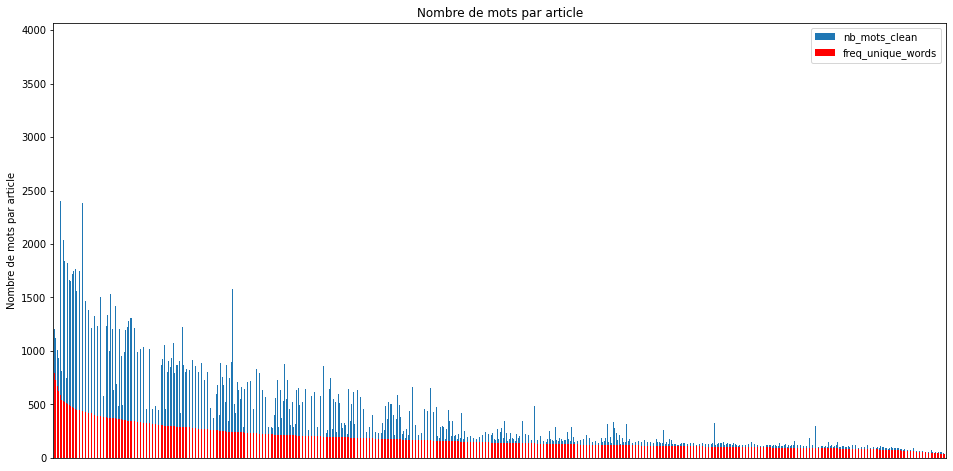

In [25]:
figure, axe = color_graph_background(1,1)

df_articles.plot(kind='bar', x='titre', y="nb_mots_clean", ax=axe, title='Nombre de mots par article')
df_articles.plot(y="freq_unique_words", x='titre', kind="bar", ax=axe, color="red")
figure.set_size_inches(16, 8, forward=True)

plt.ylabel("Nombre de mots par article")
plt.xlabel("")
plt.xticks([])
# plt.xticks(rotation=45, ha="right")
plt.show()

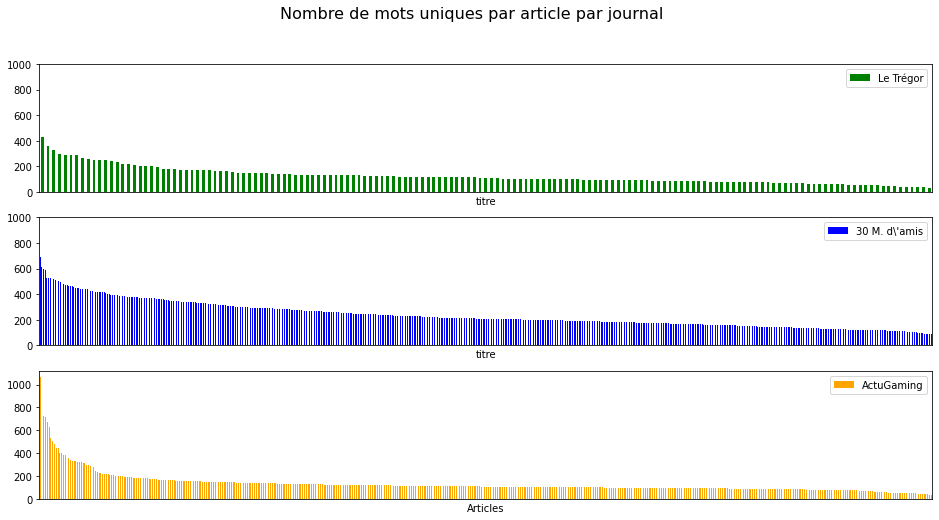

In [26]:
figure, axes = color_graph_background(len(journaux),1)

y_ticks = [i for i in range(0, 1200, 200)]

i = 0
for journal in journaux:
    df_articles[df_articles["journal"]==journal].plot(y="freq_unique_words", x='titre', label=journal, kind="bar", ax=axes[i], color=color_by_journal.get(journal, "gray"))
    axes[i].set_yticks(y_ticks)
    axes[i].set_xticks([])
    i += 1

figure.set_size_inches(16, 8, forward=True)
plt.suptitle('Nombre de mots uniques par article par journal', fontsize=16)
plt.xlabel("Articles")
plt.xticks([])
plt.show()

<div style="display: flex; background-color: Green; padding: 7px;" >

### 3.2.Nuage de mots
</div>

In [27]:
from wordcloud import WordCloud

<div style="display: flex; background-color: indigo;" >

#### 3.2.1. SANS lemmatisation
</div>

In [28]:
df_articles["texte_clean"] = [','.join(map(str, l)) for l in df_articles["clean_words"]]
df_articles["sentence_clean"] = [' '.join(map(str, l)) for l in df_articles["clean_words"]]
df_articles["texte_clean"]

913     mine,rien,annee,a,assez,chargee,sorties,gros,m...
833     depuis,lancement,nouvelle,trilogie,mythologiqu...
1112    fort,succes,critiques,commerciaux,dragon,ball,...
694     certains,jeux,marquent,vie,toujours,raisons,fa...
501     annulations,serie,crise,financiere,majeure,des...
                              ...                        
77      incendie,declare,tot,jeudi,mars,maison,habitat...
993     longtemps,repousse,rainbow,six,extraction,fina...
779     certains,peut,connu,epoque,windjammers,classiq...
54      policiers,intervenir,nuit,jeudi,vendredi,mars,...
0       jeudi,mars,rond,point,poste,lannion,plein,cent...
Name: texte_clean, Length: 1185, dtype: object

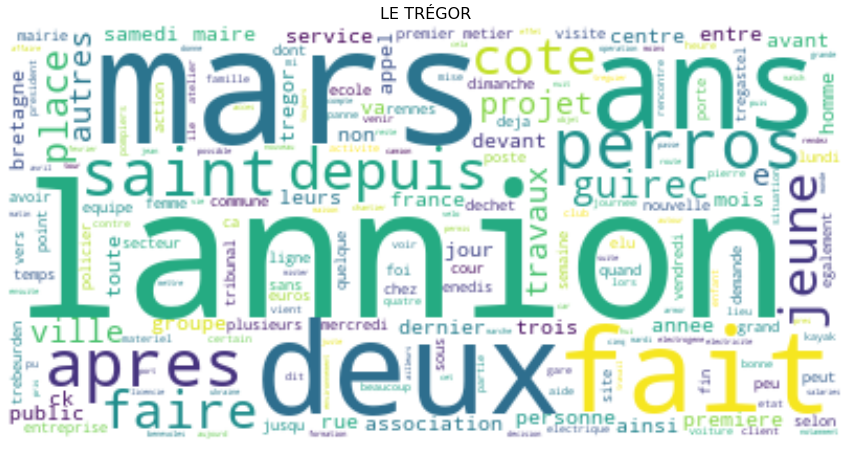

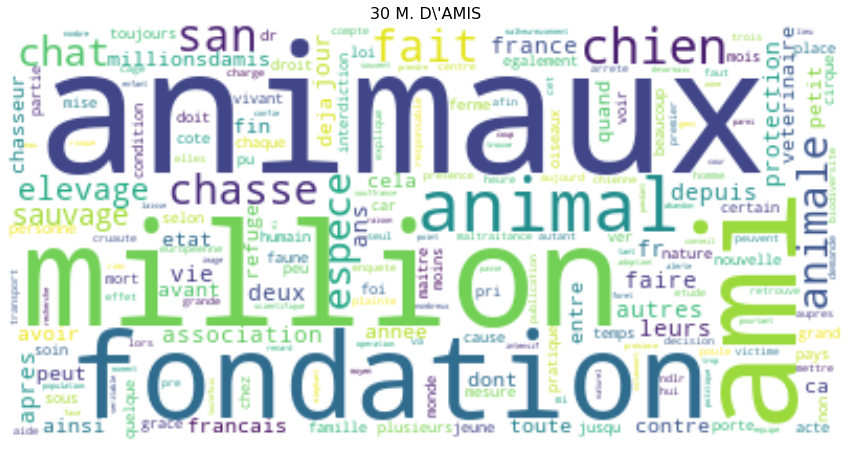

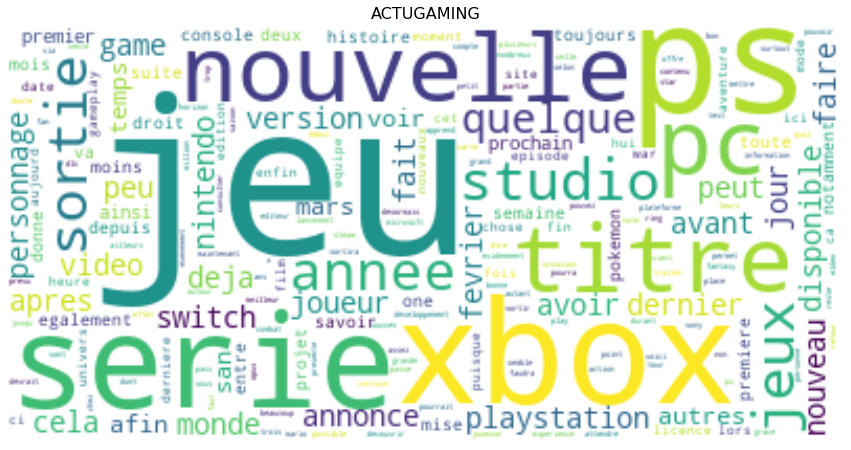

In [29]:
for journal in journaux:
    word_cloud(journal, df_articles)

<div style="display: flex; background-color: indigo;" >

#### 3.2.2. AVEC lemmatisation
</div>

<div style="display: flex; background-color: Blue; padding: 15px;" >

## 4.Entrainement d'un modèle de classification
</div>

Questions :
- Est-ce qu'on met en place l'approche td-idf ?
- Est-ce qu'on fait la lemmatisation ?
- 

<div style="display: flex; background-color: Green; padding: 7px;" >

### 4.0.Préparer les données
</div>

<div style="display: flex; background-color: indigo;" >

#### 4.0.1. Encodage de la target
</div>

In [30]:
from sklearn.preprocessing import LabelEncoder

In [31]:
random_state = 0

In [32]:
target_name = 'journal_code'
transformer_news_paper = LabelEncoder()
df_articles[target_name] = transformer_news_paper.fit_transform(df_articles["journal"])
#-- On positionne la colonne juste avant le nom du journal pour plus de lisibilité
cols = list(df_articles.columns)
cols.remove(target_name)
idx = cols.index('journal')
cols.insert(idx, target_name)
df_articles = df_articles[cols]
#--
df_articles

,titre,date_parution,journal_code,journal,auteur,tags,texte,url,mots_origine,nb_mots_origine,tranche_nb_origin,clean_words,nb_mots_clean,freq_name,freq_unique_words,texte_clean,sentence_clean
913,Tous les MMO à venir en 2022 et au-delà,28 janvier 2022 à 16:40,1,ActuGaming,Jordan,gaming,"Mine de rien, l’année 2021 a été assez chargée...",https://www.actugaming.net/sorties-mmo-2022-46...,"[mine, de, rien, l, année, 2021, a, été, assez...",4229,"(3300, 100000]","[mine, rien, annee, a, assez, chargee, sorties...",2359,"{'mine': 1, 'rien': 4, 'annee': 22, 'a': 41, '...",1066,"mine,rien,annee,a,assez,chargee,sorties,gros,m...",mine rien annee a assez chargee sorties gros m...
833,Assassin’s Creed Valhalla : L’Aube du Ragnarök...,9 mars 2022 à 12:01,1,ActuGaming,FloRizzo,gaming,Depuis le lancement de la nouvelle trilogie my...,https://www.actugaming.net/assassins-creed-val...,"[depuis, le, lancement, de, la, nouvelle, tril...",2201,"(2100, 2399]","[depuis, lancement, nouvelle, trilogie, mythol...",1202,"{'depuis': 5, 'lancement': 1, 'nouvelle': 3, '...",791,"depuis,lancement,nouvelle,trilogie,mythologiqu...",depuis lancement nouvelle trilogie mythologiqu...
1112,Pourquoi on aimerait voir un reboot de Darksta...,6 février 2022 à 11:00,1,ActuGaming,Neomantis Dee,gaming,Fort des succès critiques et commerciaux de Dr...,https://www.actugaming.net/pourquoi-on-aimerai...,"[fort, des, succès, critiques, et, commerciaux...",2062,"(1800, 2099]","[fort, succes, critiques, commerciaux, dragon,...",1119,"{'fort': 1, 'succes': 2, 'critiques': 1, 'comm...",724,"fort,succes,critiques,commerciaux,dragon,ball,...",fort succes critiques commerciaux dragon ball ...
694,Pourquoi on aimerait un retour de la licence d...,20 mars 2022 à 11:00,1,ActuGaming,Nathan Champion,gaming,"Certains jeux vous marquent à vie, et pas touj...",https://www.actugaming.net/retour-de-blob-chro...,"[certains, jeux, vous, marquent, à, vie, et, p...",2212,"(2100, 2399]","[certains, jeux, marquent, vie, toujours, rais...",1151,"{'certains': 2, 'jeux': 9, 'marquent': 1, 'vie...",713,"certains,jeux,marquent,vie,toujours,raisons,fa...",certains jeux marquent vie toujours raisons fa...
501,Corrida : ces pays où elle pourrait très proch...,15.03.2021,0,30 M. d\'amis,None,Enquête,"Annulations en série, crise financière majeure...",https://www.30millionsdamis.fr//actualites/art...,"[annulations, en, série, crise, financière, ma...",5240,"(3300, 100000]","[annulations, serie, crise, financiere, majeur...",2987,"{'annulations': 1, 'serie': 1, 'crise': 12, 'f...",693,"annulations,serie,crise,financiere,majeure,des...",annulations serie crise financiere majeure des...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,Trélévern. La chaudière met le feu au sous sol...,3 Mar 22 à 16:06,2,Le Trégor,Christophe Ganne,faits-divers,L’incendie s’est déclaré tôt ce jeudi 3 mars d...,https://actu.fr/bretagne/trelevern_22363/trele...,"[l, incendie, s, est, déclaré, tôt, ce, jeudi,...",71,"(0, 99]","[incendie, declare, tot, jeudi, mars, maison, ...",41,"{'incendie': 2, 'declare': 1, 'tot': 1, 'jeudi...",36,"incendie,declare,tot,jeudi,mars,maison,habitat...",incendie declare tot jeudi mars maison habitat...
993,Rainbow Six Extraction : Un bon jeu coop dans ...,10 février 2022 à 11:36,1,ActuGaming,Julien,gaming,"Longtemps repoussé, Rainbow Six Extraction est...",https://www.actugaming.net/rainbow-six-extract...,"[longtemps, repoussé, rainbow, six, extraction...",60,"(0, 99]","[longtemps, repousse, rainbow, six, extraction...",41,"{'longtemps': 1, 'repousse': 1, 'rainbow': 3, ...",36,"longtemps,repousse,rainbow,six,extraction,fina...",longtemps repousse rainbow six extraction fina...
779,Windjammers 2 : Que vaut le jeu de frisbee com...,8 février 2022 à 17:17,1,ActuGaming,Julien,gaming,Certains ne l’ont peut-être pas connu à l’époq...,https://www.actugaming.net/windjammers-2-que-v...,"[certains, ne, l, ont, peut, être, pas, connu,...",71,"(0, 99]","[certains, peut, connu, epoque, 

<div style="display: flex; background-color: Green; padding: 7px;" >

### 4.1.Essaie avec TF-IDF
</div>

<div style="display: flex; background-color: indigo;" >

#### 4.0.2. Calcul
</div>

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [34]:
idf_full = df_articles.copy()

In [35]:
df_articles.columns

Index(['titre', 'date_parution', 'journal_code', 'journal', 'auteur', 'tags',
       'texte', 'url', 'mots_origine', 'nb_mots_origine', 'tranche_nb_origin',
       'clean_words', 'nb_mots_clean', 'freq_name', 'freq_unique_words',
       'texte_clean', 'sentence_clean'],
      dtype='object')

In [36]:
vectorizer_idf_big = TfidfVectorizer(analyzer="word",token_pattern=get_regex_tokens(), stop_words=personnal_stop_word, ngram_range = (1,1), max_features=400)
X = vectorizer_idf_big.fit_transform(idf_full['sentence_clean'])
idf_big_df = pd.DataFrame(X.toarray(), index=idf_full.index, columns=vectorizer_idf_big.get_feature_names_out())
# ajout du site web

# Réorganisation des colonnes pour la lecture
idf_full = pd.merge(idf_full, idf_big_df, left_index=True, right_index=True)
idf_full = idf_full.drop(["mots_origine", "url", "nb_mots_origine",'auteur', 'tags', 'nb_mots_clean','freq_name','freq_unique_words'], axis=1)
# --
idf_full.head()

,titre_x,date_parution,journal_code,journal,texte,tranche_nb_origin,clean_words,texte_clean,sentence_clean,a,...,vie,vient,ville,vivant,vivants,voir,vont,vraiment,vu,xbox
913,Tous les MMO à venir en 2022 et au-delà,28 janvier 2022 à 16:40,1,ActuGaming,"Mine de rien, l’année 2021 a été assez chargée...","(3300, 100000]","[mine, rien, annee, a, assez, chargee, sorties...","mine,rien,annee,a,assez,chargee,sorties,gros,m...",mine rien annee a assez chargee sorties gros m...,0.156240,...,0.000000,0.000000,0.023754,0.0,0.0,0.033280,0.000000,0.046187,0.021185,0.040589
833,Assassin’s Creed Valhalla : L’Aube du Ragnarök...,9 mars 2022 à 12:01,1,ActuGaming,Depuis le lancement de la nouvelle trilogie my...,"(2100, 2399]","[depuis, lancement, nouvelle, trilogie, mythol...","depuis,lancement,nouvelle,trilogie,mythologiqu...",depuis lancement nouvelle trilogie mythologiqu...,0.134445,...,0.090875,0.000000,0.000000,0.0,0.0,0.029353,0.000000,0.000000,0.000000,0.071600
1112,Pourquoi on aimerait voir un reboot de Darksta...,6 février 2022 à 11:00,1,ActuGaming,Fort des succès critiques et commerciaux de Dr...,"(1800, 2099]","[fort, succes, critiques, commerciaux, dragon,...","fort,succes,critiques,commerciaux,dragon,ball,...",fort succes critiques commerciaux dragon ball ...,0.141875,...,0.031966,0.037396,0.000000,0.0,0.0,0.000000,0.041138,0.042989,0.078871,0.000000
694,Pourquoi on aimerait un retour de la licence d...,20 mars 2022 à 11:00,1,ActuGaming,"Certains jeux vous marquent à vie, et pas touj...","(2100, 2399]","[certains, jeux, marquent, vie, toujours, rais...","certains,jeux,marquent,vie,toujours,raisons,fa...",certains jeux marquent vie toujours raisons fa...,0.108477,...,0.024441,0.000000,0.135238,0.0,0.0,0.047367,0.031454,0.065738,0.000000,0.028885
501,Corrida : ces pays où elle pourrait très proch...,15.03.2021,0,30 M. d\'amis,"Annulations en série, crise financière majeure...","(3300, 100000]","[annulations, serie, crise, financiere, majeur...","annulations,serie,crise,financiere,majeure,des...",annulations serie crise financiere majeure des...,0.287261,...,0.000000,0.022270,0.052666,0.0,0.0,0.018446,0.000000,0.000000,0.046969,0.000000


<div style="display: flex; background-color: indigo;" >

#### 4.0.3. Préparer le test et train
</div>

In [37]:
from sklearn.model_selection import train_test_split

In [38]:
numeric_cols = get_numeric_columns_names(idf_full, verbose=verbose)
numeric_cols.remove(target_name)
numeric_cols

['a',
 'abandon',
 'abattage',
 'acte',
 'action',
 'actuellement',
 'adoption',
 'afin',
 'age',
 'agit',
 'agriculture',
 'aide',
 'ailleurs',
 'ainsi',
 'alerte',
 'amis',
 'an',
 'animal',
 'animale',
 'animaux',
 'annee',
 'annees',
 'annonce',
 'ans',
 'apres',
 'arrete',
 'arrivee',
 'assez',
 'association',
 'associations',
 'aucun',
 'aucune',
 'aujourd',
 'aupres',
 'autant',
 'autour',
 'autres',
 'avant',
 'avoir',
 'barometre',
 'beaucoup',
 'benevoles',
 'besoin',
 'biodiversite',
 'bon',
 'bonne',
 'ca',
 'cage',
 'car',
 'cas',
 'cause',
 'cela',
 'celle',
 'celui',
 'centre',
 'certaines',
 'certains',
 'cet',
 'ceux',
 'chaque',
 'charge',
 'chasse',
 'chasseurs',
 'chat',
 'chats',
 'chez',
 'chien',
 'chienne',
 'chiens',
 'chose',
 'ci',
 'cirques',
 'code',
 'comment',
 'compagnie',
 'compris',
 'compte',
 'conditions',
 'confie',
 'confirme',
 'conseil',
 'conservation',
 'contre',
 'cote',
 'cotes',
 'coup',
 'cours',
 'cruaute',
 'cur',
 'danger',
 'date',
 'de

In [39]:
# On prend uniquement les colonnes qui nous intéresse (identifiée précédemment)
X_train_idf, X_test_idf, y_train_idf, y_test_idf = train_test_split(idf_full[numeric_cols], idf_full[target_name], test_size=0.2, random_state=random_state)
print(f" Train : {X_train_idf.shape} et {y_train_idf.shape} --- Test : {X_test_idf.shape} et {y_test_idf.shape}")

 Train : (948, 400) et (948,) --- Test : (237, 400) et (237,)


<div style="display: flex; background-color: indigo;" >

#### 4.0.4. Prédiction
</div>

In [40]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB,BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import LinearSVC

In [50]:
verbose = 0

#Create classifier
model_list = {
    "LogisticR":LogisticRegression(random_state=random_state, verbose=verbose),
    "SVC":svm.SVC(random_state=random_state, verbose=verbose), # SCORE de 0.643333
    "KNN":KNeighborsClassifier(n_neighbors=3), # SCRORE de 0.558333
    "LinearSVC":LinearSVC(random_state=random_state, verbose=verbose),
    "naiveGaussianNB":GaussianNB(),
    "MultinomialNB": MultinomialNB(),
    "ComplementNB": ComplementNB(),
    "BernoulliNB":BernoulliNB()
}

# Train the model using the training sets
model_dic_idf, scores_idf = fit_and_test_models(model_list, X_train=X_train_idf, Y_train=y_train_idf, X_test=X_test_idf, Y_test=y_test_idf, verbose=verbose)

score_all_class_df = pd.DataFrame(scores_idf).set_index("Modeli")
score_all_class_df.round(decimals=3)
score_all_class_df = score_all_class_df.sort_values(by="R2", ascending=False)
score_all_class_df

,Class,Model,R2,fit time,fit seconde
Modeli,,,,,
BernoulliNB,,BernoulliNB,0.987342,00:00:00,0.009029
SVC,,SVC,0.983122,00:00:00,0.094621
LinearSVC,,LinearSVC,0.983122,00:00:00,0.016288
LogisticR,,LogisticR,0.974684,00:00:00,0.062008
KNN,,KNN,0.970464,00:00:00,0.013071
ComplementNB,,ComplementNB,0.953586,00:00:00,0.007071
naiveGaussianNB,,naiveGaussianNB,0.949367,00:00:00,0.013146
MultinomialNB,,MultinomialNB,0.945148,00:00:00,0.006220


In [45]:
from sklearn.model_selection import GridSearchCV

In [46]:
grid_params_BernoulliNB = { 'alpha' : [0,1],
                            'binarize' : [0.0, 0.5,1],
                            'fit_prior' : [True,False]
                            }

In [47]:
cross_validation = 3
grid_model_list = {
    "Grid_BernoulliNB":GridSearchCV(estimator=BernoulliNB(), param_grid=grid_params_BernoulliNB, cv=cross_validation, verbose=verbose),
}

In [51]:
# Train the model using the training sets
model_dic_idf_grid, scores_idf_grid = fit_and_test_models(grid_model_list, X_train=X_train_idf, Y_train=y_train_idf, X_test=X_test_idf, Y_test=y_test_idf, scores=scores_idf, verbose=verbose)

score_grid_idf = pd.DataFrame(scores_idf_grid).set_index("Modeli")
score_grid_idf.round(decimals=3)
score_grid_idf = score_grid_idf.sort_values(by="R2", ascending=False)
score_grid_idf

,Class,Model,R2,fit time,fit seconde
Modeli,,,,,
BernoulliNB,,BernoulliNB,0.987342,00:00:00,0.009029
Grid_BernoulliNB,,Grid_BernoulliNB,0.987342,00:00:00,0.392077
SVC,,SVC,0.983122,00:00:00,0.094621
LinearSVC,,LinearSVC,0.983122,00:00:00,0.016288
LogisticR,,LogisticR,0.974684,00:00:00,0.062008
KNN,,KNN,0.970464,00:00:00,0.013071
ComplementNB,,ComplementNB,0.953586,00:00:00,0.007071
naiveGaussianNB,,naiveGaussianNB,0.949367,00:00:00,0.013146
MultinomialNB,,MultinomialNB,0.945148,00:00:00,0.006220


<div style="display: flex; background-color: Green; padding: 7px;" >

### 4.1.Essaie avec W2V

In [52]:
from gensim import downloader as g_dwnl

In [53]:
g_dwnl.info()["models"].keys()

dict_keys(['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis'])

In [ ]:
glove_vectors = g_dwnl.load('glove-wiki-gigaword-100')

<div style="display: flex; background-color: indigo;" >

#### 4.0.2. Calcul
</div>

<div style="display: flex; background-color: indigo;" >

#### 4.0.3. Préparer le test et train
</div>

<div style="display: flex; background-color: Green; padding: 7px;" >

### 4.1.Test de plusieurs modèles
</div>

*   Entrainer un modèle de classification
*   Afficher la matrice de confusion
*   Calculer l'accuracy, la précision et le recall
*   Votre modèle est-il soumis à un overfitting ?

In [ ]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB,BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import LinearSVC

<div style="display: flex; background-color: Green; padding: 7px;" >

### 4.2.Optimisation du modèle retenu
</div>

<div style="display: flex; background-color: Green; padding: 7px;" >

### 4.3.Sauvegarde du modèle entrainé
</div>

<div style="display: flex; background-color: Green; padding: 7px;" >

### 4.4.Prédiction
</div>

<div style="display: flex; background-color: Blue; padding: 15px;" >

## ANNEXE
</div>